# Admissions markets with a single score and MNL choice

Max Kapur | maxkapur.com

*N.B.* This is a working document, more of a set of personal notes than a finished product. Please see my other Github repositories for somewhat more polished discussions of admissions markets.

------

(I have moved most of the text to the LaTeX file now. Just archiving a few bits I want to have in Markdown format here.)

## Demand function
The first quantity we need to define is the *demand function,* which indicates how many students will attend each school given the school's quality $\gamma$ and some information about the school's selectivity. Specifically, each school sets a *cutoff* $p_c$ and admits all students whose score exceeds the cutoff. The demand function $D_c(\gamma, p)$ indicates how many students come to school $c$, representated as a fraction of the total number of students in the market. Observe that $D_c$ is a function not just of $p_c$ but also of the cutoffs at all the other schools, since if another school becomes more selective, the demand at $c$ may increase.

Let's figure out this function. First, sort the schools by cutoff, i.e. so that

$$p_1 \leq p_2 \leq \dots \leq p_{|C|}$$

Ties may be broken arbitrarily.

Then there are only $|C| + 1$ possible consideration sets for each student: 

| Symbol          | Consideration&nbsp;set                          | Probability           |
|-----------------|--------------------------------------------|-----------------------|
| $C_{[0]}$       | $\varnothing$                              | $p_1$                 |
| $C_{[1]}$       | $\left\{ c_1 \right\}$                     | $p_2 - p_1$           |
| $C_{[2]}$       | $\left\{ c_1, c_2 \right\}$                | $p_3 - p_2$           |
| $\vdots$        | $\vdots$                                   | $\vdots$              |
| $C_{[|C| - 1]}$ | $\left\{ c_1, \dots, c_{|C| - 1} \right\}$ | $p_{|C|} - p_{|C|-1}$ |
| $C_{[|C|]}$     | $\left\{ c_1, \dots, c_{|C|} \right\}$     | $1 - p_{|C|}$         |

This greatly simplifies the demand function. Letting $p_{|C|+1} \equiv 1$,

$$\begin{equation}D_c = \sum_{d=c}^{|C|} 
\underbrace{\frac{{\gamma_c}}{ \sum_{i=1}^d {\gamma_i}}}_{\substack{\text{prob. of choosing  }\\ c\text{ from assortment}}} 
\overbrace{\left(p_{d+1} - p_{d}\right)}^{\substack{\text{prob. of having}\\ \text{assortment }C_{[d]}}} \end{equation}$$

If at least one school has $p_c = 0$, then every student can get in somewhere, and $\sum_c D_c = 1$. Generally, there are $p_1$ students who get in nowhere, and $\sum_c D_c = 1 - p_1$.

## Computation

Let's get a computational environment going. First I define a container for the market information (capacity is discussed later), then the demand and appeal functions. I also define a function that returns the matrix $A$ discussed above; note that $A$ depends on $p$ via permutation. Finally, I define a market that computes the equilibrium for a given market using a generic t&acirc;tonnement procedure.

(Shifted all this to `OneTest.jl`.)

In [1]:
include("OneTest.jl")

using Plots
using LaTeXStrings

### Quick usage example
Create a market and compute the equilibrium.

In [2]:
taipei = Market([2., 1., 2.], [0.2, 0.3, 0.1])
p_star, nit = equilibrium(taipei, p0=:random)

([0.6264241117657114, 0.3999999999999999, 0.7632120558828558], 3)

In [3]:
A, sort_order = demandmatrix(taipei, p_star)
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

3×3 Matrix{Float64}:
 -0.731059   0.0   0.30874
  0.731059  -1.0   0.113579
  0.0        0.0  -0.422319

In [4]:
B * diagm(p_star)

3×3 Matrix{Float64}:
 -0.457953   0.0   0.235634
  0.457953  -0.4   0.0866849
  0.0        0.0  -0.322319

In [5]:
inv(B)

3×3 Matrix{Float64}:
 -1.36788  -0.0  -1.0
 -1.0      -1.0  -1.0
  0.0       0.0  -2.36788

## Checking the appeal and demand functions

Check that the matrices work as described:

In [6]:
mkt = Market(5)
p = rand(5)

A, sort_order = demandmatrix(mkt, p)

demand(mkt, p)[sort_order] ≈ A * p[sort_order] + mkt.gamma[sort_order]

true

Alternatively, 

In [7]:
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

demand(mkt, p) ≈ B * p + mkt.gamma

true

The following fact is handy, because inverting a triangular matrix is easier than inverting a square matrix:

In [8]:
inv(A)[inv_sort_order, inv_sort_order] ≈ inv(B)

true

Same check for the appeal function:

In [9]:
appeal(mkt, p)[sort_order] ≈ (A * p[sort_order] .^2 + mkt.gamma[sort_order])/2 &&
appeal(mkt, p) ≈ (A[inv_sort_order, inv_sort_order] * p .^2 + mkt.gamma)/2

true

In [14]:
mkt = Market(5)
p = rand(5)

A, sort_order = demandmatrix(mkt, p)
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

5×5 Matrix{Float64}:
 -0.152087    0.0   0.0         0.0        0.0
  0.0234514  -1.0   0.0785212   0.664665   0.102616
  0.0513152   0.0  -0.337408    0.0        0.0
  0.0464828   0.0   0.155636   -0.664665   0.203395
  0.0308372   0.0   0.103251    0.0       -0.306011

In [15]:
B\(mkt.capacities - mkt.gamma)

5-element Vector{Float64}:
 -0.18451131007259586
  0.2858351309876368
 -0.021642459960877086
  0.2809601244583723
  0.04327931750399199




- Stable matching. In 
- Market-clearing matching. A *semicentralized* admissions procedure like that used in Korea, in which the government determines a quota (i.e. capacity) of students who may be admitted to each school, and schools steadily admit students with lower and lower scores over the course of several admissions rounds until they fill their quota. The result is market-clearing cutoffs. (In the idealized case, this is actually a decentralized deferred acceptance algorithm; in practice, there is variation in scoring practices and limits on how many schools each student can apply to that prevent the equilibrium from being achieved exactly.)
- Competitive equilibrium. A *decentralized* admissions procedure like that used by private universities in the US. In this case, schools designate their own capacity, which is not necessarily a physical limitation on the number of students it can receive but rather a way of maintaining the school's selective reputation. In this case, schools must observe their demand from year over year and adjust their admissions cutoffs accordingly. If the adjustment process fits certain regularity conditions, then this process converges to the equilibrium defined above. The equilibrium is a fixed point of a tatonnement process. (In fact, a version of this process is how the function `quickeq()` computes equilibria.) (Show that this is a Nash EQ when schools use quality as their utility func.)

These observations are useful because if we can assume the market is at equilibrium, we can reduce the number of parameters:
- If $q$ and $\gamma$ are given, then there is only one equilibrium cutoff vector $p$, which we can find using `quickeq()`.
- If $\gamma$ and $p > 0$ are given, and we are told that the market is at equilibrium, then we can assume that $q = D(\gamma, p)$, which we can find using the `demand()` function.
- If $D$ and $p$ are given, and we are told that the market is at equilibrium, then we can solve for $\gamma$, as described [in a separate notebook](https://github.com/maxkapur/StudentPrefsRevOpt/blob/main/2_ReverseOptimization.ipynb). If $p>0$, we can additionally assume that $q = D$. 

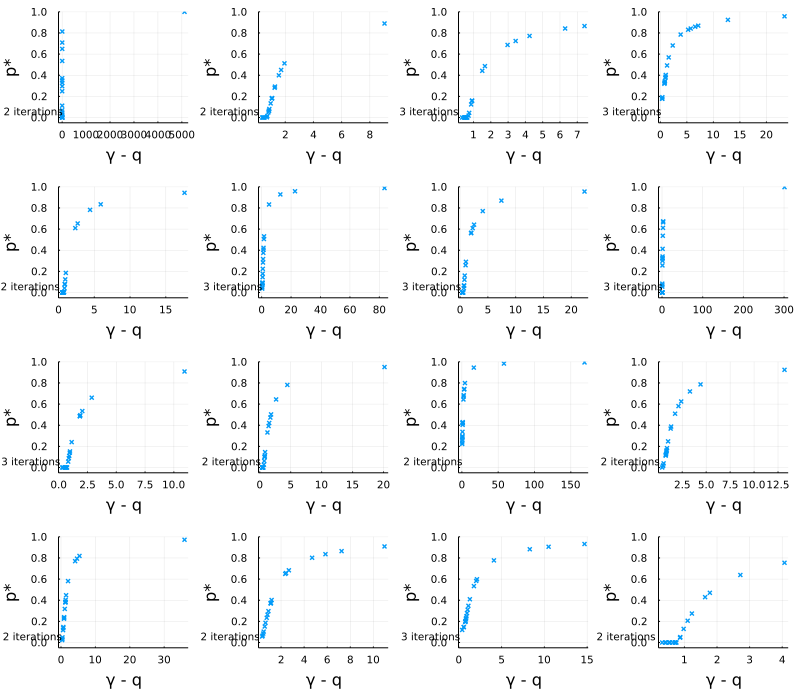

In [20]:
function heuristic_demo(np=3)
    pl = plot(layout=(np, np), legend=nothing, ylim=(-0.05,1), yticks=0:0.2:1, size=(800, 700),
              xlabel="γ - q", ylabel="p*",
              xtickfontsize=7, ytickfontsize=7)
    xlim = [0, 0]
    for j in 1:np^2
        mkt = Market(20)
        p_star, nit = equilibrium(mkt)
        x = mkt.gamma - mkt.capacities
        x = mkt.gamma ./ mkt.capacities
        xlim = [min(xlim[1], minimum(x)), max(xlim[2], maximum(x))]
        scatter!(pl, subplot=j, x, p_star, ms=2, m=:x)
        annotate!(pl, subplot=j, anns=[(.10, .0, text("$nit iterations", :right, :bottom, 7))], )
    end
    xlim .+= .05 * (xlim[2] - xlim[1]) * [-1, 1]
    
#     plot!(pl, xlim=(-.1, .1))
    
    return pl
end
    
pl = heuristic_demo(4)

savefig(pl, "paper/plots/gammaq-pstar.pdf")
savefig(pl, "paper/plots/gammaq-pstar.png")

pl

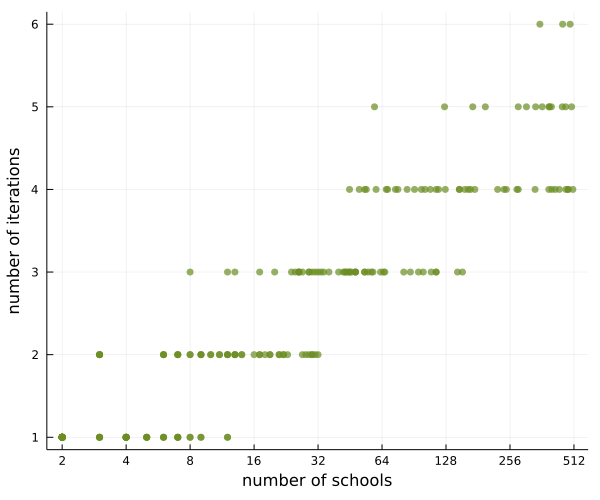

In [83]:
function heuristic_effectiveness(nmarkets=200, maxnschools=512)
    tix = 2 .^ (1:10)
    pl = plot(size=(600, 500), xaxis=:log, xticks=(tix, string.(tix)),
              xlabel="number of schools", ylabel="number of iterations",
              xtickfontsize=8, ytickfontsize=8, legend=nothing)
    
    n_schools = 1 .+ trunc.(Int, exp.( log(maxnschools) * rand(nmarkets)))
    n_it = zeros(Int, nmarkets)
    
    for i in 1:nmarkets
        mkt = Market(n_schools[i])
        _, n_it[i] = equilibrium(mkt)
    end
    
    scatter!(pl, n_schools, n_it, msw=0, alpha=.7, c=:olivedrab)
    
    return pl
end

pl = heuristic_effectiveness()

savefig(pl, "paper/plots/schools-nit.pdf")
savefig(pl, "paper/plots/schools-nit.png")

pl

In [79]:
mkt = Market(6)
p_star, nit = equilibrium(mkt)

A, sort_order = demandmatrix(mkt, p_star)
demand(mkt, p_star)[sort_order] ≈ A * p_star[sort_order] + mkt.gamma[sort_order]

true

In [5]:
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

6×6 Matrix{Float64}:
 -0.287749    0.0   0.0         0.0396838   0.0        0.0
  0.0678506  -1.0   0.0449909   0.0231617   0.248809   0.470403
  0.0461063   0.0  -0.160231    0.015739    0.0        0.0
  0.0         0.0   0.0        -0.137911    0.0        0.0
  0.113526    0.0   0.0752776   0.0387535  -0.469808   0.0
  0.0602668   0.0   0.0399622   0.0205729   0.220999  -0.470403

In [352]:
idx = p_star .> 0

6-element BitVector:
 1
 0
 0
 1
 0
 0

In [353]:
demand(mkt, p_star)

6-element Vector{Float64}:
 0.15842191056062965
 0.21676289577981173
 0.279139394838357
 0.011985400648549865
 0.1411434002164737
 0.19254699795617808

In [354]:
B[:, idx] * inv(B)[idx, :] * (mkt.capacities - mkt.gamma) + mkt.gamma

6-element Vector{Float64}:
 0.15842191056062963
 0.21676289577981164
 0.2791393948383569
 0.011985400648549804
 0.14114340021647367
 0.19254699795617802

In [355]:
# Block matrix described below
# [ 0 T ;
#   0 I ] =
round.((B[:, idx] * inv(B)[idx, :])[sort_order, sort_order], digits=4)

6×6 Matrix{Float64}:
 0.0  0.0  0.0  0.0  -0.2613  -0.2613
 0.0  0.0  0.0  0.0  -0.3365  -0.3365
 0.0  0.0  0.0  0.0  -0.1701  -0.1701
 0.0  0.0  0.0  0.0  -0.2321  -0.2321
 0.0  0.0  0.0  0.0   1.0      0.0
 0.0  0.0  0.0  0.0   0.0      1.0

## References

- Abdulkadiroğlu, Atila, Yeon-Koo Che, and Yosuke Yasuda. 2015. &ldquo;Expanding &lsquo;Choice&rsquo; in School Choice.&rdquo; *American Economic Journal: Microeconomics* 7, no. 1 (Feb.): 1&ndash;42.